
# Projeto PokemonDataPipeline com Airflow

Neste tutorial, iniciaremos a nossa primeira DAG com o Apache Airflow. O objetivo do projeto é criar uma pipeline que agende a execução de um script Python para obter dados de uma API de dados de Pokémon.

Arquivos Principais:

**DAG do Airflow (pokemon_data_pipeline.py):**

Neste arquivo, utilizaremos o Airflow para orquestrar a execução do script get_pokemon_data.py. A DAG pode ser configurada para rodar em intervalos específicos.

**Script Python para Obtenção de Dados (get_pokemon_data.py)**:

Utilizaremos a API Pokemon para extrair informações. Os dados obtidos serão salvos em um arquivo CSV(pokemon_data.csv):

Vamos criar o script get_data.py para realizar chamada a API pokemon e escrevemos no arquivo CSV.

Esse script vai em scripts/get_pokemon_data.py

In [ ]:
import requests
import pandas as pd
import os
import logging  

logger = logging.getLogger("airflow.task")


POKEAPI_URL = "https://pokeapi.co/api/v2/pokemon/"
CSV_FILE_PATH = "./data/pokemon_data.csv"

def get_pokemon_data(pokemon_id):
    response = requests.get(f"{POKEAPI_URL}{pokemon_id}")

    data = response.json()

    name = data["name"]
    base_experience = data["base_experience"]
    height = data["height"]
    weight = data["weight"]
    logger.info(f"get_pokemon_data {pokemon_id}: {name}")

    df = pd.DataFrame([[name, base_experience, height, weight]],
                      columns=["Name", "Base Experience", "Height", "Weight"])

    df.to_csv(CSV_FILE_PATH, mode='a', index=False, header=not os.path.exists(CSV_FILE_PATH))

def run_get_data():
    logger.info(f"Iniciando get_pokemon_data ")
    
    for pokemon_id in range(1, 6):
        get_pokemon_data(pokemon_id)

if __name__ == "__main__":
    run_get_data()


Para criar a DAG no Apache Airflow, você precisa definir um objeto DAG e adicionar tarefas a ele. Cada tarefa será uma instância de um operador que executa uma determinada ação. No caso, usamos o operador PythonOperator para executar o script Python que obtém dados.

Salvamos a DAG em dags/pokemon_data_pipeline.py

In [ ]:
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime, timedelta

import sys
sys.path.insert(0,"/opt/airflow/")
from scripts.get_pokemon_data import run_get_data

import logging
task_logger = logging.getLogger("airflow.task")

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'pokemon_data_pipeline',
    default_args=default_args,
    description='Um pipeline simples usando Airflow para obter dados de Pokemon e salvar em CSV',
    schedule_interval=timedelta(days=1),  # frequencia
)

run_task = PythonOperator(
    task_id='get_data_task',
    python_callable=run_get_data,
    provide_context=True,  # Fornece o contexto para a função
    dag=dag,
)

run_task


Para executar a DAG Airflow, você precisa iniciar o serviço do Airflow e ativar o agendamento dos DAGs. Vamos assumir que você já tenha o Apache Airflow instalado. Caso não tenha nesse link eu explico como instalar usando Docker.

Passos:
- Acesse o Ambiente Web do Airflow: No navegador e acesse http://localhost:8080

- Ative a DAG: No painel do Airflow, vá para a seção "DAGs" e localize a DAG (pokemon_data_pipeline)
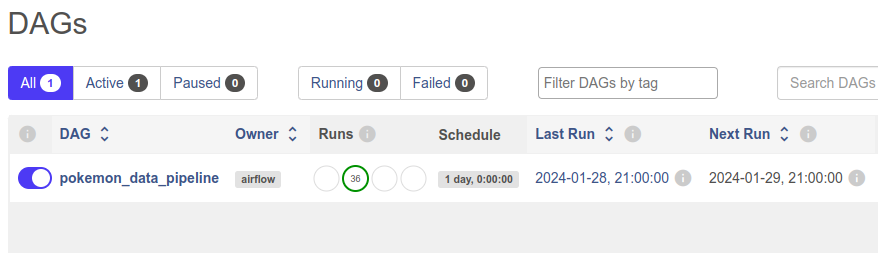

- Execute a DAG: Clicar no botão "Trigger DAG". Isso iniciará a execução do DAG imediatamente!
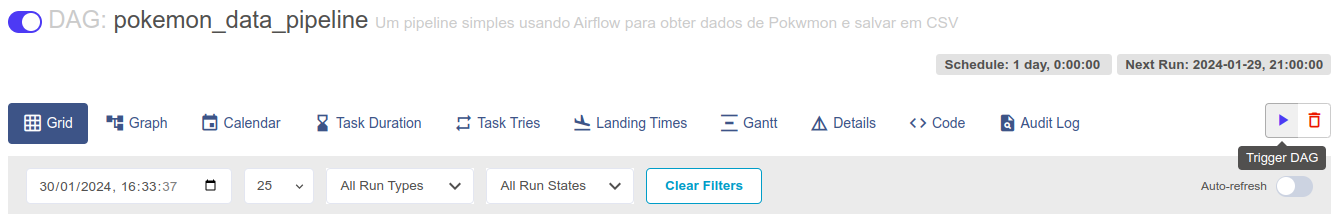

Clicando na execução de uma DAG e depois em Log vemos os pokemons que foram obtidos

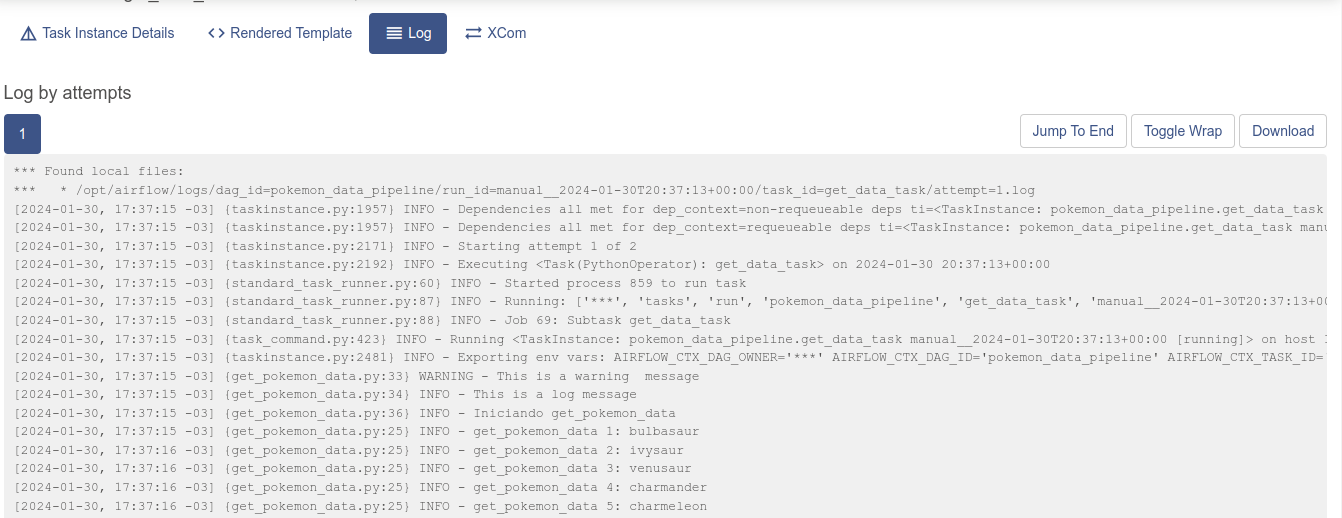

Temos os mesmo pokemons salvos no arquivo CSV

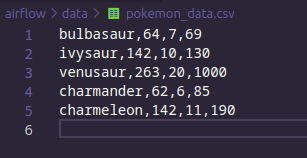

Alguns comandos úteis:

Caso de problemas rodando a DAG você pode executar localmente:

**acessar container com o servidor airflow**

docker exec -it docker_ID /bin/bash


**rodar task no terminal**

airflow tasks test pokemon_data_pipeline get_data_task 2022-01-25